In [ ]:
!pip install torch torchvision

In [ ]:
!git clone https://github.com/parth1620/Project-NST.git

fatal: destination path 'Project-NST' already exists and is not an empty directory.


In [ ]:
import torchvision.models as models
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
model = models.vgg19(pretrained=True)
vgg = model.features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
for layer in vgg.parameters():
  layer.requires_grad = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = vgg.to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
def preprocess(path, max_size=500):
  image = Image.open(path).convert("RGB")
  if max(image.size) > max_size :
      size = max_size
  else :
      size = max(image.size)
  transformation = T.Compose([
                   T.Resize(size),
                   T.ToTensor(),
                   T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
  ])
  image = transformation(image)
  image = image.unsqueeze(0)
  return image

In [ ]:
### UNIT TEST 1 ###
content_T = preprocess('/content/Project-NST/content10.jpg')
style_T = preprocess('/content/Project-NST/style10.jpg')
content_T = content_T.to(device)
style_T = style_T.to(device)
print(content_T.shape)
print(style_T.shape)


torch.Size([1, 3, 487, 487])
torch.Size([1, 3, 500, 765])


## Task 4 : Deprocess image

In [ ]:
def deprocess(img):
  image = img.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0)
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0, 1)
  return image

(487, 487, 3)


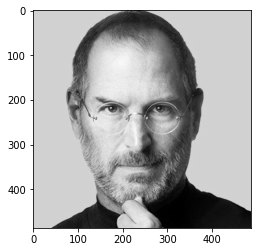

In [ ]:
### UNIT TEST 2 ###
test1 = deprocess(content_T)
print(test1.shape)
plt.imshow(test1)
plt.show()

In [ ]:
def get_features(image, model):
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '20': 'conv4_2',
      '28': 'conv5_1' 
  }
  features = {}
  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers :
      features[layers[name]] = x
  return features

In [ ]:
content_F = get_features(content_T, vgg)
style_F = get_features(style_T, vgg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def gram_matrix(image):
  b, c, h, w = image.size()
  image = image.view(c, h * w)
  matrix = torch.mm(image, image.T)
  return matrix

In [ ]:
style_gram = {layer : gram_matrix(style_F[layer]) for layer in style_F}

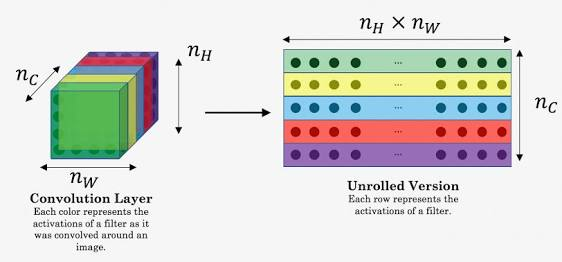

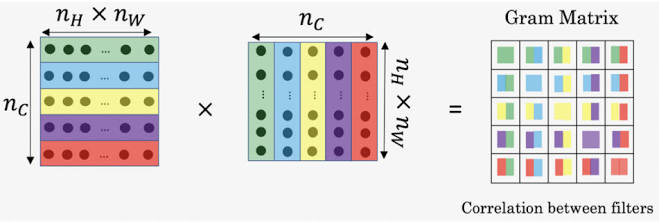

In [ ]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)
  return loss

In [ ]:
style_weight = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [ ]:
def style_loss(style_weight, target_features, style_gram):
  loss = 0
  for layer in style_weight:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    layer_gram = style_gram[layer]
    b, c, h, w = target_f.size()
    layer_loss = style_weight[layer] * torch.mean((target_gram - layer_gram)**2)
    loss += layer_loss/(h * w * c)
  return loss


In [ ]:
### INIT DATA ###
target = content_T.clone().requires_grad_(True).to(device)
target_F = get_features(target, vgg)
c_loss = content_loss(target_F['conv4_2'], content_F['conv4_2'])
s_loss = style_loss(style_weight, target_F, style_gram)
print("C_LOSS : ", c_loss)
print("S_LOSS :", s_loss)

C_LOSS :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
S_LOSS : tensor(3823.5757, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
optimizer = torch.optim.Adam([target], lr=0.003)
alpha = 1
beta = 1e5
show_every = 500
epochs = 3000

In [ ]:
def total_loss(c_loss, s_loss, alpha, beta ):
  return alpha * c_loss + beta * s_loss

In [ ]:
result = []
for epoch in range(epochs):
  target_F = get_features(target, vgg)
  c_loss = content_loss(target_F['conv4_2'], content_F['conv4_2'])
  s_loss = style_loss(style_weight, target_F, style_gram)
  loss = total_loss(c_loss, s_loss, alpha, beta)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % show_every == 0 :
    print(f'Total loss at epoch {epoch}: {loss}')
    result.append(deprocess(target.detach()))


Total loss at epoch 0: 382357568.0
Total loss at epoch 500: 100290064.0
Total loss at epoch 1000: 54183856.0
Total loss at epoch 1500: 25974992.0
Total loss at epoch 2000: 13500514.0
Total loss at epoch 2500: 8138527.5


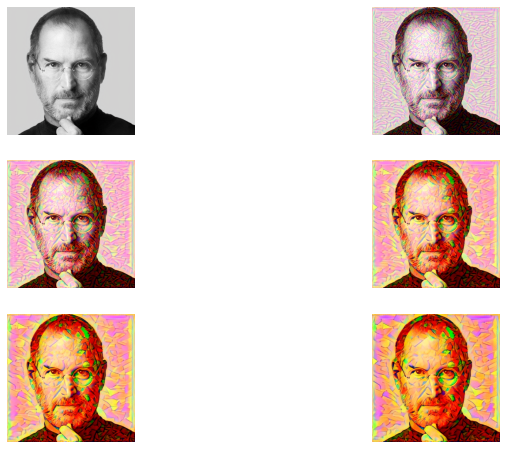

In [ ]:
figure = plt.figure(figsize=(12, 8))
for i in range(len(result)):
    plt.subplot(3,2,i+1)
    plt.imshow(result[i])
    plt.axis("off")
plt.show()


In [ ]:
target_img = deprocess(target.detach())
content_img = deprocess(content_T)
target_cp = target_img.copy()
content_cp = content_img.copy()
style = Image.open('/content/Project-NST/style10.jpg')

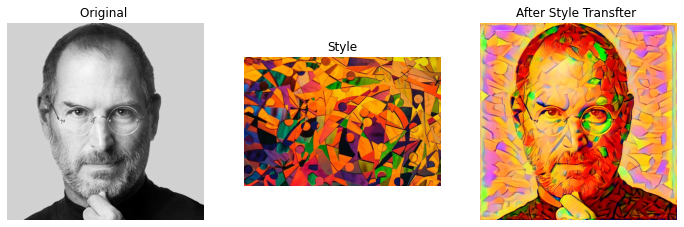

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax1.title.set_text('Original ')
ax3.title.set_text('After Style Transfter ')
ax2.title.set_text('Style')
ax1.imshow(content_cp)
ax2.imshow(style)
ax3.imshow(target_cp)
plt.show()